In [2]:
import sys, os
import torch
import numpy as np
import utils
from torch.nn import Module, Parameter
import torch.optim as opt
from utils import preprocess
# from umap import UMAP
from sklearn.decomposition import PCA

In [26]:
class cfrmModel(Module):
    def __init__(self, dir, N=3, batch_size=100, lr=1e-3, dropout=0.1, init = "random"):
        super().__init__()
        self.batch_size = batch_size
        self.alpha = torch.FloatTensor([1, 1, 1])
        self.dropout = dropout
        self.N = N
        # data
        counts_rna = np.loadtxt(os.path.join(dir, 'GxC1.txt')).T
        counts_atac = np.loadtxt(os.path.join(dir, 'RxC2.txt')).T
        
        counts_rna = preprocess(counts = counts_rna, mode = "quantile", modality = "RNA")
        counts_atac = preprocess(counts = counts_atac, mode = "quantile", modality= "ATAC")

        self.G = torch.FloatTensor(counts_rna)
        self.R = torch.FloatTensor(counts_atac)
        self.A = torch.FloatTensor(np.loadtxt(os.path.join(dir, 'RxG.txt')))
        assert self.A.shape[0] == self.R.shape[1]
        assert self.A.shape[1] == self.G.shape[1]
        self.label_g = torch.LongTensor(np.loadtxt(os.path.join(dir, 'gene_label.txt')))
        self.label_c1 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C1.txt'), skiprows=1, usecols=[1]))
        self.label_c2 = torch.LongTensor(np.loadtxt(os.path.join(dir, 'cell_label_C2.txt'), skiprows=1, usecols=[1]))

        # learnable parameters
        if init == "svd":
            u_g, s_g, v_g = torch.svd(self.G)
            self.C_1 = u_g[:, :N]
            self.C_g = v_g[:, :N]        

            u_r, s_r, v_r = torch.svd(self.R)
            self.C_2 = u_r[:, :N]
            self.C_r = v_r[:, :N]

        if init == "random":
            self.C_1, _ = torch.qr(torch.randn((self.G.shape[0],N)))
            self.C_2, _ = torch.qr(torch.randn((self.R.shape[0],N)))
            self.C_g, _ = torch.qr(torch.randn((self.G.shape[1],N)))
            self.C_r, _ = torch.qr(torch.randn((self.R.shape[1],N)))


        self.A_1g = self.C_1.t() @ self.G @ self.C_g
        self.A_2r = self.C_2.t() @ self.R @ self.C_r
        self.A_rg = self.C_r.t() @ self.A @ self.C_g

        loss = self.loss()
        for l in loss:
            print(l.item())
        
       
    def loss(self):
        loss1 = (self.G - self.C_1 @ self.A_1g @ self.C_g.t()).pow(2).mean()
        loss2 = (self.R - self.C_2 @ self.A_2r @ self.C_r.t()).pow(2).mean()
        loss3 = (self.A - self.C_r @ self.A_rg @ self.C_g.t()).pow(2).mean()
        loss = self.alpha[0] * loss1 + self.alpha[1] * loss2 + self.alpha[2] * loss3

        return loss, self.alpha[0] * loss1, self.alpha[1] * loss2, self.alpha[2] * loss3

    def train_func(self, T):
        for t in range(T):
            for mode in ['C_1', 'C_2', 'C_r', 'C_g']:
                if mode == 'C_1':
                    M = self.alpha[0] * (self.G @ self.C_g @ self.C_g.t() @ self.G.t())
                    s_g, u_g = torch.eig(M, eigenvectors=True)
                    self.C_1 = u_g[:, :self.N]

                elif mode == 'C_2':
                    M = self.alpha[1] * (self.R @ self.C_r @ self.C_r.t() @ self.R.t())
                    s_g, u_g = torch.eig(M, eigenvectors=True)
                    self.C_2 = u_g[:, :self.N]

                elif mode == 'C_r':
                    M = self.alpha[1] * (self.R.t() @ self.C_2 @ self.C_2.t() @ self.R) + self.alpha[2] * (self.A @ self.C_g @ self.C_g.t() @ self.A.t())
                    s_g, u_g = torch.eig(M, eigenvectors=True)
                    self.C_r = u_g[:, :self.N]

                elif mode == 'C_g':
                    M = self.alpha[0] * (self.G.t() @ self.C_1 @ self.C_1.t() @ self.G) + self.alpha[2] * (self.A.t() @ self.C_r @ self.C_r.t() @ self.A)
                    s_g, u_g = torch.eig(M, eigenvectors=True)
                    self.C_g = u_g[:, :self.N]
            
            self.A_1g = self.C_1.t() @ self.G @ self.C_g
            self.A_2r = self.C_2.t() @ self.R @ self.C_r
            self.A_rg = self.C_r.t() @ self.A @ self.C_g
            
            loss, loss1, loss2, loss3 = self.loss()
            print('Epoch {}, Training Loss: {:.4f}'.format(t+1, loss.item()))
            info = [
                'loss RNA: {:.5f}'.format(loss1.item()),
                'loss ATAC: {:.5f}'.format(loss2.item()),
                'loss gene act: {:.5f}'.format(loss3.item())
            ]
            for i in info:
                print("\t", i)

                    


In [21]:
model = cfrmModel(dir = '../data/simulated/2batches_3clusts', N=3, dropout=0, init = "random")
model.train_func(T=1000)

1.1030724048614502
1.0019930601119995
0.10066074132919312
0.0004186651494819671
Epoch 1, Training Loss: 0.4057
	 loss RNA: 0.31630
	 loss ATAC: 0.08903
	 loss gene act: 0.00042
Epoch 2, Training Loss: 0.2717
	 loss RNA: 0.22465
	 loss ATAC: 0.04666
	 loss gene act: 0.00042
Epoch 3, Training Loss: 0.2709
	 loss RNA: 0.22424
	 loss ATAC: 0.04626
	 loss gene act: 0.00042
Epoch 4, Training Loss: 0.2707
	 loss RNA: 0.22420
	 loss ATAC: 0.04603
	 loss gene act: 0.00042
Epoch 5, Training Loss: 0.2705
	 loss RNA: 0.22420
	 loss ATAC: 0.04591
	 loss gene act: 0.00042
Epoch 6, Training Loss: 0.2705
	 loss RNA: 0.22420
	 loss ATAC: 0.04587
	 loss gene act: 0.00042
Epoch 7, Training Loss: 0.2705
	 loss RNA: 0.22419
	 loss ATAC: 0.04585
	 loss gene act: 0.00042
Epoch 8, Training Loss: 0.2705
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 9, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 10, Training Loss: 0.2704
	 loss RNA: 0.2

KeyboardInterrupt: 

In [22]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

In [23]:
label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

None


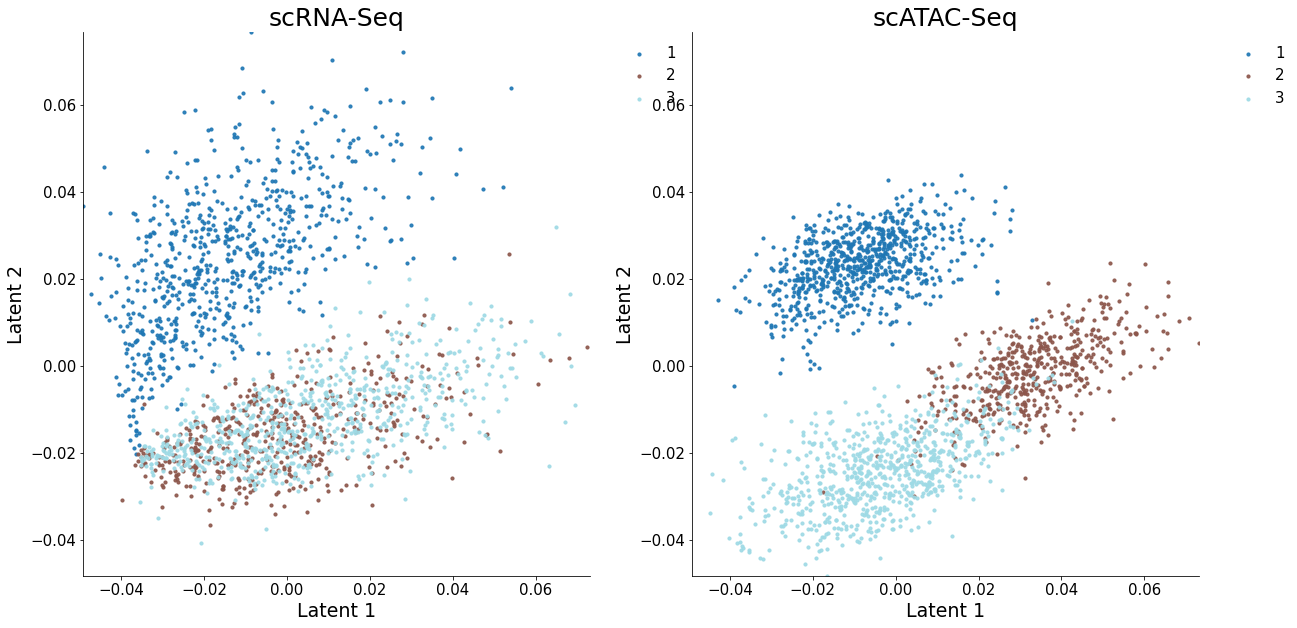

In [24]:
utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [27]:
model = cfrmModel(dir = '../data/simulated/2batches_3clusts', N=3, dropout=0, init = "svd")
model.train_func(T=1000)

0.2704484164714813
0.2241944968700409
0.04583536460995674
0.0004185508587397635
Epoch 1, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 2, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 3, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 4, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042
Epoch 5, Training Loss: 0.2704
	 loss RNA: 0.22419
	 loss ATAC: 0.04584
	 loss gene act: 0.00042


KeyboardInterrupt: 

None


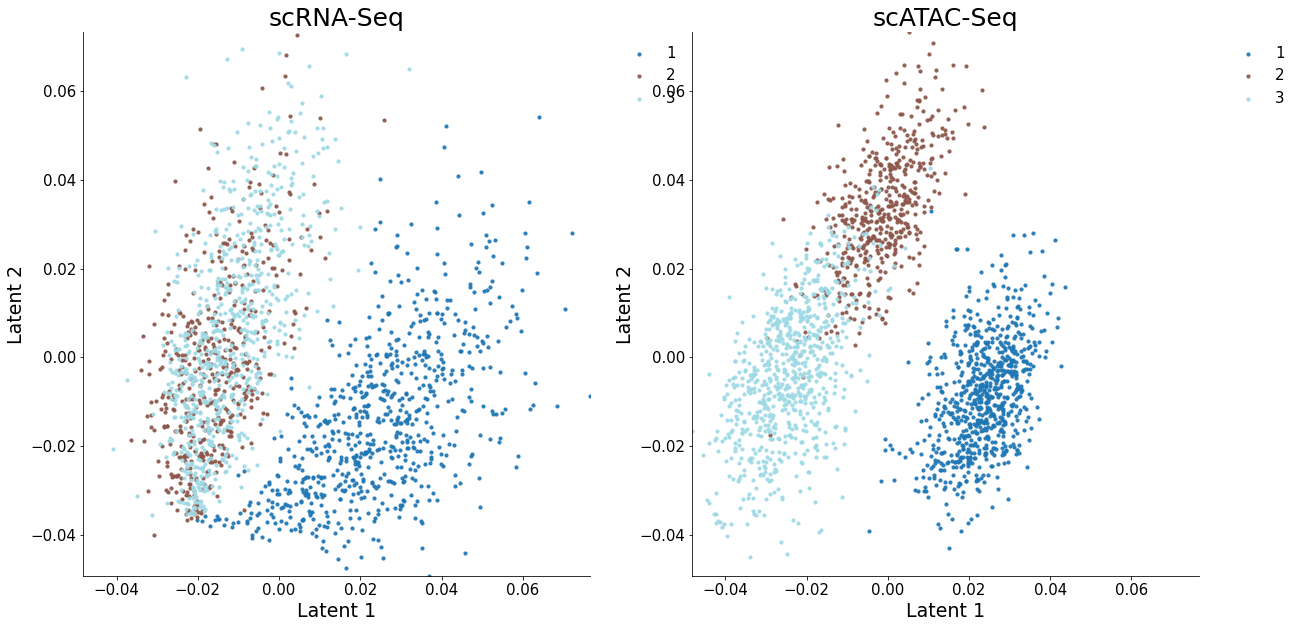

In [28]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [29]:
model = cfrmModel(dir = '../data/simulated/2batches_6clusts', N=3, dropout=0, init = "random")
model.train_func(T=100)

1.1414905786514282
1.0413411855697632
0.09973078221082687
0.0004186659352853894
Epoch 1, Training Loss: 0.3652
	 loss RNA: 0.28159
	 loss ATAC: 0.08321
	 loss gene act: 0.00042
Epoch 2, Training Loss: 0.2638
	 loss RNA: 0.21496
	 loss ATAC: 0.04846
	 loss gene act: 0.00042
Epoch 3, Training Loss: 0.2599
	 loss RNA: 0.21157
	 loss ATAC: 0.04789
	 loss gene act: 0.00042
Epoch 4, Training Loss: 0.2596
	 loss RNA: 0.21145
	 loss ATAC: 0.04776
	 loss gene act: 0.00042
Epoch 5, Training Loss: 0.2596
	 loss RNA: 0.21144
	 loss ATAC: 0.04771
	 loss gene act: 0.00042
Epoch 6, Training Loss: 0.2595
	 loss RNA: 0.21144
	 loss ATAC: 0.04767
	 loss gene act: 0.00042
Epoch 7, Training Loss: 0.2595
	 loss RNA: 0.21144
	 loss ATAC: 0.04764
	 loss gene act: 0.00042
Epoch 8, Training Loss: 0.2595
	 loss RNA: 0.21144
	 loss ATAC: 0.04763
	 loss gene act: 0.00042
Epoch 9, Training Loss: 0.2595
	 loss RNA: 0.21144
	 loss ATAC: 0.04761
	 loss gene act: 0.00042
Epoch 10, Training Loss: 0.2595
	 loss RNA: 0.2

KeyboardInterrupt: 

None


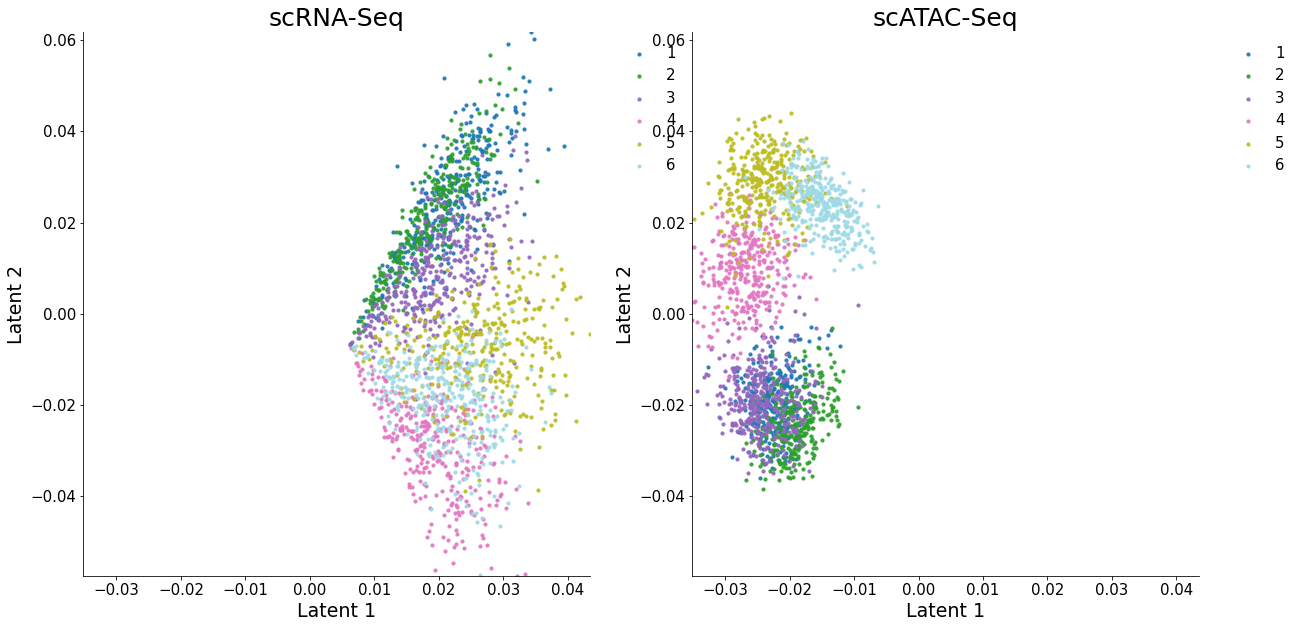

In [30]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)

In [31]:
model = cfrmModel(dir = '../data/simulated/2batches_6clusts', N=3, dropout=0, init = "svd")
model.train_func(T=100)

0.25944381952285767
0.21143664419651031
0.04758860915899277
0.0004185651778243482
Epoch 1, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 2, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 3, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 4, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 5, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042
Epoch 6, Training Loss: 0.2594
	 loss RNA: 0.21144
	 loss ATAC: 0.04759
	 loss gene act: 0.00042


KeyboardInterrupt: 

None


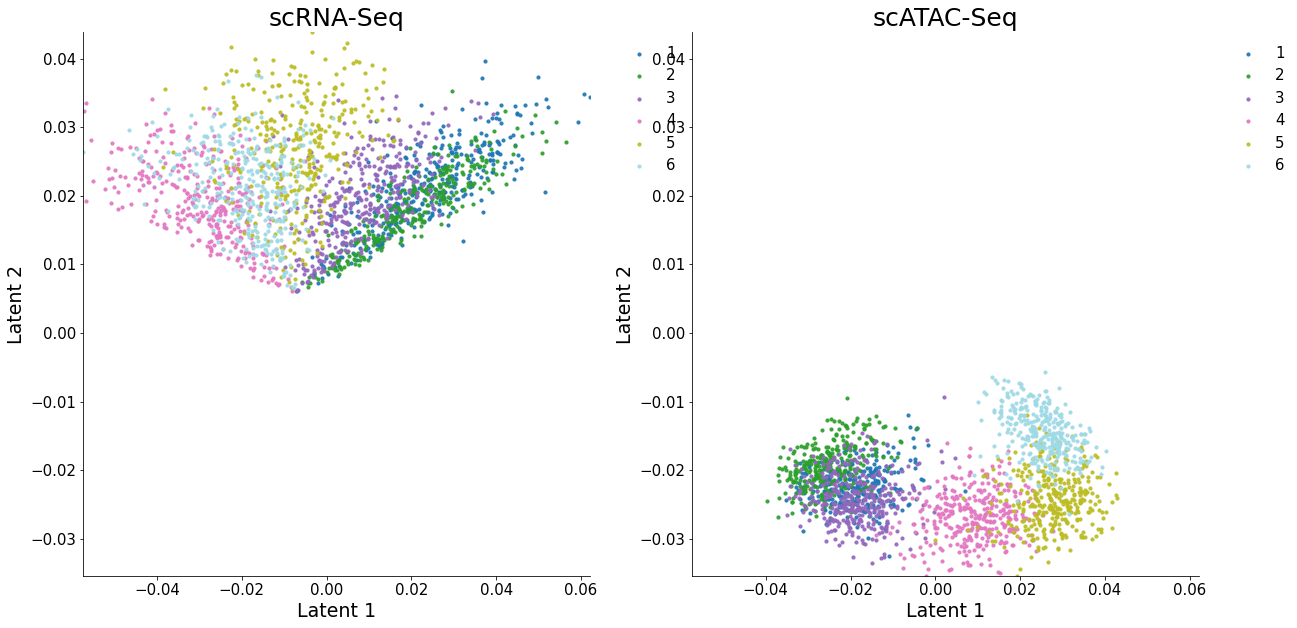

In [32]:
# torch.save(model, "b2c6.pth")
# model = torch.load("b2c6.pth")
from umap import UMAP

pca_op = PCA(n_components = 2)
umap_op = UMAP(n_components = 2, n_neighbors = 15, min_dist = 0.4) 
z_rna = model.C_1.detach().numpy()
z_atac = model.C_2.detach().numpy()
z = pca_op.fit_transform(np.concatenate((z_rna, z_atac), axis = 0))
z_rna = z[:z_rna.shape[0],:]
z_atac = z[z_rna.shape[0]:,:]

label_rna = [x for x in model.label_c1.numpy()]
label_atac = [x for x in model.label_c2.numpy()]
label_rna = model.label_c1.numpy()[:,None]
label_atac = model.label_c2.numpy()[:,None]

utils.plot_latent(z_rna, z_atac, label_rna, label_atac, mode= "separate", save = None)